In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re, string, time

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix

from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, 
                                    NearMiss, 
                                    InstanceHardnessThreshold,
                                    CondensedNearestNeighbour,
                                    EditedNearestNeighbours,
                                    RepeatedEditedNearestNeighbours,
                                    AllKNN,
                                    NeighbourhoodCleaningRule,
                                    OneSidedSelection,
                                    TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
tweets = pd.read_excel('/content/drive/MyDrive/Copy of Tweet_NFT.xlsx')

In [4]:
print(tweets.duplicated().sum())

0


In [5]:
tweets.isnull().sum()

id                      0
tweet_text              0
tweet_created_at        0
tweet_intent        31089
dtype: int64

In [6]:
tweets.head()

id                                         tweet_text  \
0  1212762.0  @crypto_brody @eCoLoGy1990 @MoonrunnersNFT @It...   
1  1212763.0  Need Sick Character artâ_x009d_“#art #artist #...   
2  1212765.0  @The_Hulk_NFT @INagotchiNFT @Tesla @killabears...   
3  1212766.0  @CryptoBatzNFT @DarekBTW The first project in ...   
4  1212767.0  @sashadysonn The first project in crypto with ...   

           tweet_created_at  tweet_intent  
0  2022-08-06T16:56:36.000Z     Community  
1  2022-08-06T16:56:36.000Z      Giveaway  
2  2022-08-06T16:56:35.000Z  Appreciation  
3  2022-08-06T16:56:35.000Z     Community  
4  2022-08-06T16:56:34.000Z     Community

In [7]:
tweets['tweet_intent'].unique() # sentiment

array(['Community', 'Giveaway', 'Appreciation', 'Presale', 'Whitelist',
       'pinksale', 'Done', 'Interested', 'Launching Soon', nan],
      dtype=object)

In [8]:
tweets['tweet_intent'].nunique()

9

In [9]:
tweets = tweets.drop(['id', 'tweet_created_at'], axis=1)

After Droping the 'id' and 'tweet_created_at' columns, I find that there are 12K+ rows are douplicated

In [10]:
print(tweets.duplicated().sum())

12959


In [11]:
tweets = tweets.drop_duplicates() # droping duplicates in row-wise

In [12]:
tweets.shape

(114494, 2)

Here below you can find two tweets that have identical text but refering to different person. Person name are unnecessary when it comes to sentiment analysis since names are independent (have no releation to the context).

In [13]:
tweets.tweet_text[3]

'@CryptoBatzNFT @DarekBTW The first project in crypto with move to earn  #AstroBirdz. Big things happening with this project with release of marketplace and  #NEST.\n#FeedToEarn . \n #birdzarmy \n #luna #BTC #web3 #gem\n #NFT #NFTCommunity \n https://t.co/cU23XoROMR https://t.co/qUvOj4YSYP'

In [14]:
tweets.tweet_text[4]

'@sashadysonn The first project in crypto with move to earn  #AstroBirdz. Big things happening with this project with release of marketplace and  #NEST.\n#FeedToEarn . \n #birdzarmy \n #luna #BTC #web3 #gem\n #NFT #NFTCommunity \n https://t.co/IakfZgYXow https://t.co/a2p0nKxlfd'

Here are sentiment labels. Now we shall now analyse the dataset by its distribution. Because it's important that we have almost small amount of examples for given classes. we conclude that no.of samples for each sentiment/label assigned is biased 

Text(0.5, 1.0, 'Sentiment Data Distribution')

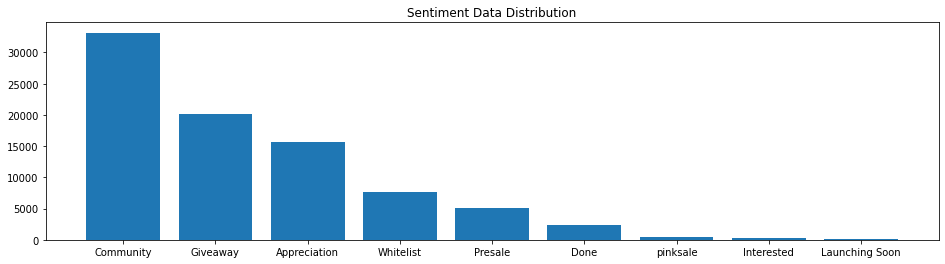

In [15]:
val_count = tweets.tweet_intent.value_counts()

plt.figure(figsize=(16,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [16]:
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"haha", " haha", text)
    return text 

In [17]:
text = '@Hello all please help @me   but@notme'

[x for x in text.split() if not x.startswith("@")]

['all', 'please', 'help', 'but@notme']

In [18]:
re.sub(r'(\s)@\w+', r'\1', '@virat please prepare your text') # removes names that refer with @


'@virat please prepare your text'

In [19]:
exclude = set(string.punctuation) # Set of all special characters
remove_digits = str.maketrans('', '', string.digits) # Set of all digits

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def preprocess_text(text, stem=False):
    text = ' '.join([x for x in text.split() if not x.startswith("@")]) # removes names that refer with @
    text = re.sub(r'http\S+', '', text)
    text = ' '.join([x.upper() if x.startswith('#') else x.lower() for x in text.split()])
    text = re.sub("'", '', text) # remove the quotation marks if any
    text = ''.join(ch for ch in text if ch not in exclude)
    text = text.translate(remove_digits) # remove the digits
    text = re.sub(" +", " ", text) # remove extra spaces
    text = decontraction(text)
    text = re.sub(r'[^\x00-\x7F]',' ', text)
    text = ' '.join([x for x in text.split() if not x.startswith("xd")]) 
    text = ' '.join([x for x in text.split() if not x.startswith("xf")]) 
    # text = ' '.join( [w for w in text.split() if (len(w)>1) | (w.lower()=='a')])
    text = text.strip()
    tokens = []
    for token in text.split():
      if token not in stop_words:
        if stem:
          tokens.append(stemmer.stem(token))
        else:
          tokens.append(token)
    return " ".join(tokens)

In [20]:
tweets.tweet_text = tweets.tweet_text.apply(lambda x: preprocess_text(x))

After cleaning all the refered name tags, url links, specal characters and non-ascii codes are removied and then found out that there are even more duplicates present so I again drop duplicates.

In [21]:
print(tweets.duplicated().sum())
tweets = tweets.drop_duplicates()


66067


In [22]:
tweets.head(20)

tweet_text  tweet_intent
0   x new cryptocurrency born fans chihuahua meme ...     Community
1   need sick character art art ARTIST ARTISTS ANI...      Giveaway
2                        great choice tesla good luck  Appreciation
3   first project crypto move earn ASTROBIRDZ big ...     Community
5                                  registered saphire       Presale
6   bridged sold gt price l rank rank hr nr fp l o...      Giveaway
7   project best gamefi project bsc multistage def...     Whitelist
8   feature great community nft artists nft collec...     Community
10                                            depends  Appreciation
11                                            promote     Community
12  registered raffle free mint super low supply F...       Presale
13  definitely gonna missed nft lfgggggg INCUBEXWE...     Community
15                       gtgtgt ready join ltltlt via       Presale
17  comedy church rewarded apostles took leap fait...     Whitelist
19  one top nft projects space runner game brings ...     Community
23  dapperundeadsquad first non generative pfp nft...     Community
24  hero world game bsc safu badge testnet game re...     Whitelist
25  celebrate new NFT community giving away NFT ra...      Giveaway
26                                      good hear fam  Appreciation
27  x cryptocurrency born fans chihuahua meme comm...     Community

**Aaww.. It is clean and tidy now. Now let's see some word cloud visualizations of it.**

### Word Cloud

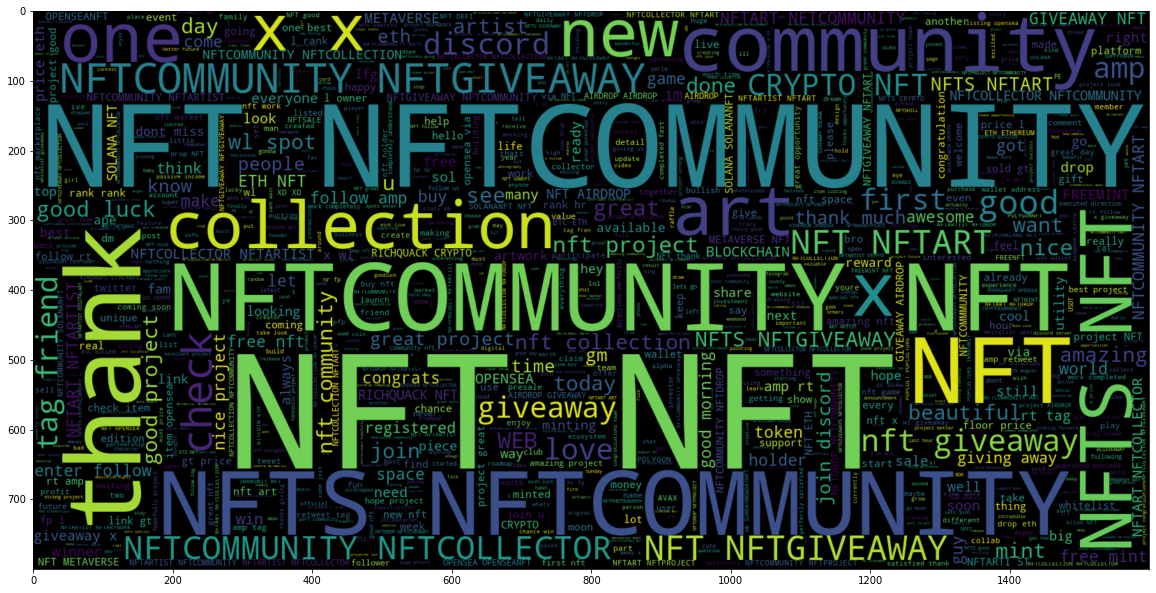

In [23]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(tweets[tweets.tweet_intent.isnull() == False].tweet_text))
plt.imshow(wc , interpolation = 'bilinear')

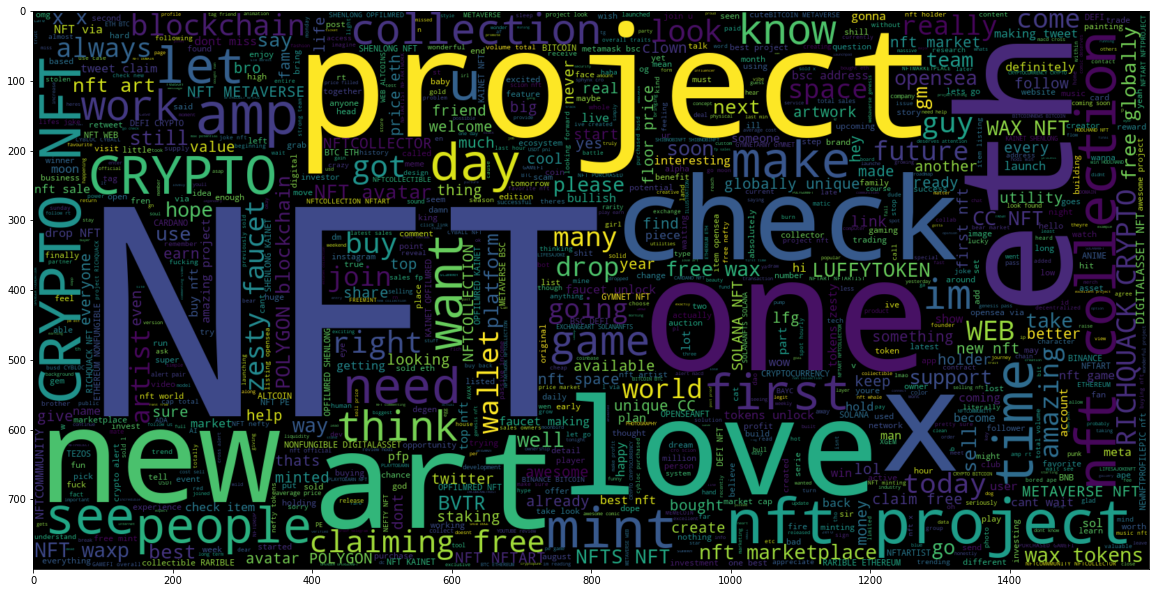

In [24]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(tweets[tweets.tweet_intent.isnull() == True].tweet_text))
plt.imshow(wc , interpolation = 'bilinear')

## Model Selection: Train/Test Data Split

In [25]:
tweets_test = tweets[tweets.tweet_intent.isnull()==True].tweet_text
tweets = tweets[tweets.tweet_intent.isnull()==False]

In [26]:
# find the max length of a sentence in the tweets
lengths = [len(line.split(' ')) for line in tweets.tweet_text.to_list()]
max_length = max(lengths)

In [27]:
tweets['tweet_length'] = lengths

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
tweets.head()

tweet_text  tweet_intent  \
0  x new cryptocurrency born fans chihuahua meme ...     Community   
1  need sick character art art ARTIST ARTISTS ANI...      Giveaway   
2                       great choice tesla good luck  Appreciation   
3  first project crypto move earn ASTROBIRDZ big ...     Community   
5                                 registered saphire       Presale   

   tweet_length  
0            16  
1            20  
2             5  
3            21  
5             2

# Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization.**

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`word_index` contains the index for each word

`vocab_size` represents the total number of word in the data corpus

Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from `pad_sequence` to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [29]:
def tokenize(text):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=40000,
      filters='')
  tokenizer.fit_on_texts(text)
  # tensor = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(text).to_list(), mode='tfidf')
  tensor = tokenizer.texts_to_sequences(text)

  return tensor, tokenizer


def text_to_sequence(text, num_examples=None):
  # creating cleaned input, output pairs
  input_tensor, inp_tokenizer = tokenize(text)
  print(input_tensor)

  
  # Padding the input and output tensor to the maximum length
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                maxlen=max_length,
                                                                padding='post')
  
  word_index = inp_tokenizer.word_index
  return input_tensor, inp_tokenizer, word_index

In [30]:
labels = tweets.tweet_intent.unique().tolist()
labels

['Community',
 'Giveaway',
 'Appreciation',
 'Presale',
 'Whitelist',
 'pinksale',
 'Done',
 'Interested',
 'Launching Soon']

### Label Encoding 
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [31]:
# def target_data(sentiment):
le = LabelEncoder()
le.fit(tweets.tweet_intent.to_list())

label_data = le.transform(tweets.tweet_intent).reshape(-1,1)
print("label_data shape:", label_data.shape)
# return label_data

label_data shape: (31216, 1)


In [32]:
input_tensor, inp_tokenizer, word_index= text_to_sequence(tweets.tweet_text)
print(word_index)
vocab_size = len(word_index)+1
print(vocab_size)


[[5, 36, 91, 1769, 1048, 3871, 728, 11, 1253, 1547, 47, 180, 1254, 2080, 2161, 358], [124, 1009, 1010, 19, 19, 168, 262, 1027, 6447, 4208, 9780, 1, 35, 3052, 2162, 3872, 774, 6447, 276, 1381], [12, 944, 4574, 6, 73], [52, 4, 9, 729, 97, 5009, 115, 265, 1346, 4, 766, 238, 2761, 6448, 5656, 1151, 63, 39, 428, 1, 3], [111, 2633], [4209, 102, 117, 40, 122, 130, 130, 234, 513, 222, 122, 190, 9781, 55, 117, 375, 13, 3, 1], [4, 44, 153, 4, 89, 9782, 9783, 571, 2524, 9784, 1, 424, 9785, 2429, 277, 266, 203, 1290, 112, 176, 65, 358, 4, 1290, 153], [1213, 12, 11, 1, 262, 1, 492], [4210], [954], [111, 270, 37, 24, 271, 450, 402, 106, 78], [251, 410, 834, 1, 9786, 1724, 2762, 3, 2], [3873, 150, 18, 7697, 78], [4575, 3626, 1152, 9787, 1255, 6449, 2634, 696, 2893, 65, 27, 92, 669, 30, 215, 9788, 6450, 9789, 3053, 1684, 5657, 1, 10], [33, 206, 1, 86, 81, 2635, 82, 793, 2894, 114, 82, 461, 94, 330, 432, 11, 81, 101, 309, 18, 48, 333, 7698], [14283, 52, 1814, 1548, 411, 1, 28, 7699, 2763, 9790, 2022, 6

## Train and Test Split

In [33]:
# Creating training and validation sets using an 80-20 split
X_train, X_val, y_train, y_val = train_test_split(input_tensor, label_data, test_size=0.2, random_state = 143)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((24972, 45), (6244, 45), (24972, 1), (6244, 1))

## Random Over-sampling
The below code block uses Scikit learn over-sampling method to randomly repeat some minority samples and balance the number of samples between the data-set.

In [34]:
ros = RandomOverSampler(random_state=777)
ros_x_train, ros_y_train = ros.fit_resample(X_train, y_train)

In [35]:
X_train.shape, y_train.shape

((24972, 45), (24972, 1))

In [36]:
ros_x_train.shape, ros_y_train.shape

((67005, 45), (67005,))

In [37]:
def onehotencode_labels(y_train, y_val):
  ohe = OneHotEncoder()
  ohe.fit(y_train)
  y_train_enc = ohe.transform(y_train)
  y_val_enc = ohe.transform(y_val)

  y_train_csr = csr_matrix(y_train_enc)
  y_val_csr = csr_matrix(y_val_enc)
  y1 = y_train_csr.todense()
  y2 = y_val_csr.todense()
  return y1, y2 

ros_y_train, y_val = onehotencode_labels(ros_y_train.reshape(-1, 1), y_val)

In [38]:
ros_y_train.shape

(67005, 9)

# Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it. 

**Word Embedding** is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use **Transfer Learning**. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like **GloVe & Word2Vec** gives more insights for a word which can be used for classification. If you want to learn more about the Word Embedding, please refer some links that I left at the end of this notebook.


In this notebook, I use **GloVe Embedding from Stanford AI** which can be found [here](https://nlp.stanford.edu/projects/glove/)

## Using Glove Vectors

In [39]:
def loading_embeddings():
    ''' loading glove embeddings '''
    embeddings_index = {}
    glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    glove_file.close()
    return embeddings_index

print('Found %s word vectors.' %len(loading_embeddings()))

Found 400000 word vectors.


In [40]:
MAX_NB_WORDS = 50000
def prepare_embedding_matrix(word_index, EMBEDDING_DIM = 100):
    ''' preparing embedding matrix with our data set '''
    embeddings_index = loading_embeddings()
    num_words = min(MAX_NB_WORDS, len(word_index))
    embedding_matrix = np.zeros((num_words + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NB_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, num_words+1

In [41]:
embedding_matrix, emb_vocab_size = prepare_embedding_matrix(word_index)

In [42]:
len(word_index)

32621

In [43]:
emb_vocab_size

32622

In [44]:
EMBEDDING_DIM = 100
LR = 1e-3
BATCH_SIZE = 512

In [45]:
embedding_matrix.shape

(32622, 100)

In [46]:
embedding_layer = tf.keras.layers.Embedding(emb_vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_length,
                                          trainable=False)

# Model Training - LSTM
While developing a DL model, we should keep in mind key things like Model Architecture, Hyperparameter Tuning, and Performance of the model. As you can see in the word cloud, some words are predominantly featured in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc. That's why we use Sequence Models.
### Sequence Model

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction. 

For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors. 

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [47]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

## Model 1

In [48]:
sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(9, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45)]              0         
                                                                 
 embedding (Embedding)       (None, 45, 100)           3262200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 45, 100)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 41, 64)            32064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               33024 

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [51]:
history = model.fit(ros_x_train, ros_y_train, batch_size=512, epochs=20, 
                    validation_data=(X_val, y_val), callbacks=[ReduceLROnPlateau])

Epoch 1/20
131/131 [==============================] - 69s 402ms/step - loss: 1.2894 - accuracy: 0.5179 - val_loss: 1.1438 - val_accuracy: 0.6006 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 54s 411ms/step - loss: 0.7084 - accuracy: 0.7409 - val_loss: 0.8769 - val_accuracy: 0.7018 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 52s 395ms/step - loss: 0.5663 - accuracy: 0.7986 - val_loss: 0.8044 - val_accuracy: 0.7236 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 53s 408ms/step - loss: 0.4888 - accuracy: 0.8257 - val_loss: 0.7913 - val_accuracy: 0.7378 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 52s 398ms/step - loss: 0.4403 - accuracy: 0.8438 - val_loss: 0.7522 - val_accuracy: 0.7530 - lr: 0.0010
Epoch 6/20
131/131 [==============================] - 53s 409ms/step - loss: 0.4043 - accuracy: 0.8568 - val_loss: 0.7374 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 7/20
131/131 [==============================] 

# Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

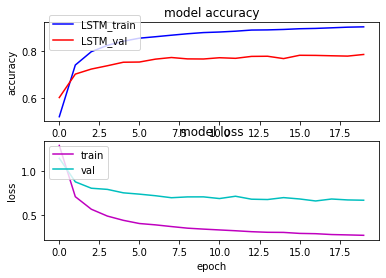

In [52]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], bbox_to_anchor=(0., 1.02, 2.2, .102), loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

## Model2

In [53]:
model2 = tf.keras.Sequential([
     # embedding layer
     embedding_layer,
     # bidirectional LSTM layers
     Bidirectional(LSTM(64, 
                        dropout=0.5, 
                        recurrent_dropout=0.5, 
                        return_sequences=True)),
     Bidirectional(LSTM(64, 
                        dropout=0.5, 
                        recurrent_dropout=0.5, 
                        return_sequences=True)),
     Bidirectional(LSTM(16, 
                        dropout=0.5, 
                        recurrent_dropout=0.5)),
     # Classification head
     Dense(256, activation='relu', kernel_regularizer='l2'),
     Dense(64, activation='relu', kernel_regularizer='l2'),
     Dense(16, activation='relu', kernel_regularizer='l2'),
     Dense(9, activation='softmax')    
 ]) 

In [54]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 100)           3262200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 45, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 45, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 256)               8448      
                                                        

In [55]:
model2.compile(optimizer=Adam(learning_rate=LR), loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [56]:
history2 = model2.fit(ros_x_train, ros_y_train, batch_size=1024, epochs=20, 
                    validation_data=(X_val, y_val), callbacks=[ReduceLROnPlateau])

Epoch 1/20
66/66 [==============================] - 94s 1s/step - loss: 2.9966 - accuracy: 0.2578 - val_loss: 2.7341 - val_accuracy: 0.0440 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - 79s 1s/step - loss: 1.8144 - accuracy: 0.4998 - val_loss: 1.9319 - val_accuracy: 0.2654 - lr: 0.0010
Epoch 3/20
66/66 [==============================] - 78s 1s/step - loss: 1.2704 - accuracy: 0.6360 - val_loss: 1.5997 - val_accuracy: 0.5322 - lr: 0.0010
Epoch 4/20
66/66 [==============================] - 78s 1s/step - loss: 1.0746 - accuracy: 0.6916 - val_loss: 1.4316 - val_accuracy: 0.6019 - lr: 0.0010
Epoch 5/20
66/66 [==============================] - 77s 1s/step - loss: 0.9724 - accuracy: 0.7252 - val_loss: 1.3323 - val_accuracy: 0.6373 - lr: 0.0010
Epoch 6/20
66/66 [==============================] - 80s 1s/step - loss: 0.9024 - accuracy: 0.7521 - val_loss: 1.2402 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 7/20
66/66 [==============================] - 79s 1s/step - loss: 0.8449 - a

# Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

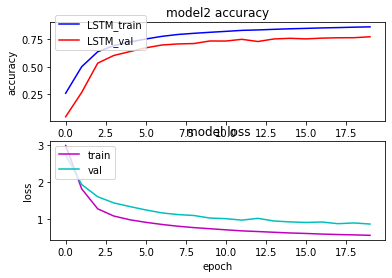

In [57]:
s, (at, al) = plt.subplots(2,1)

at.plot(history2.history['accuracy'], c= 'b')
at.plot(history2.history['val_accuracy'], c='r')
at.set_title('model2 accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], bbox_to_anchor=(0., 1.02, 2.2, .102), loc='upper left')

al.plot(history2.history['loss'], c='m')
al.plot(history2.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

# picking better model of above: [Model-1]

In [58]:
scores = model.predict(X_val, verbose=1, batch_size=1024)

7/7 [==============================] - 1s 28ms/step


In [59]:
pred_labels = []
for score in scores:
  pred_labels.append(np.argmax(score))

In [60]:
true_labels = []
for val in y_val:
  true_labels.append(np.argmax(val))

In [61]:
index_2words = dict((v,k) for k,v in word_index.items())
X_val_reverse=[]
X_val_list = [np.trim_zeros(val) for val in X_val]
for i in X_val_list:
  lines = []
  for j in i:
    lines.append(index_2words[j+1])
  X_val_reverse.append(' '.join(lines))

In [63]:
len(true_labels)

6244

In [82]:
test_results =pd.DataFrame()
test_results['x_val'] = X_val_reverse
test_results['pred_labels'] = pred_labels
test_results['true_labels_str'] = [''.join(le.inverse_transform([i])) for i in true_labels]
test_results['true_labels'] = true_labels

In [83]:
test_results

x_val  pred_labels  \
0                                             one sites            0   
1     claim drop nfts strongest pretty flokimooni sc...            1   
2     beautiful xbaaaeccdacdabbb access xaeaeabafdbf...            7   
3     also bbyc personal matic xd tasks day join han...            1   
4     krillin space goblins lived greatdumbapes gran...            1   
...                                                 ...          ...   
6239                   nftgiveaways x xeebbabebdcffbebc            0   
6240  airdrop solananfts goodluck projects giveaway ...            3   
6241  via worth matic nftjapan evil sleep art nftcol...            1   
6242     via nfts beautifully est network popcult witch            1   
6243  apehaterclub styles gymnetarmy cubex apehaterc...            3   

     true_labels_str  true_labels  
0       Appreciation            0  
1          Community            1  
2           Giveaway            3  
3          Community            1  
4       Appreciation            0  
...              ...          ...  
6239    Appreciation            0  
6240        Giveaway            3  
6241        Giveaway            3  
6242    Appreciation            0  
6243       Community            1  

[6244 rows x 4 columns]

# Testing for the unknow tweets data

In [84]:
test_tensor, test_tokenizer, test_word_index= text_to_sequence(tweets_test)

[[2395, 2, 95, 43, 9176, 14, 1710, 231, 2, 1815, 464, 1276, 3173, 2, 295, 347, 43, 7, 1, 423, 413, 1710, 231, 1442, 1443, 855, 591], [33, 168, 338, 104, 1, 281, 721, 542, 2845, 73, 3174, 262, 3175, 94, 44, 47, 127, 1, 10, 9177, 34, 239, 3], [114, 112, 148, 134, 136, 13, 214, 41, 110, 9178, 214, 1, 214], [741, 106, 424, 393, 3], [433, 6370, 1, 76, 1444, 1037, 60], [11, 1, 1, 742, 856, 304, 216, 204, 25, 800, 592], [126], [963], [2846, 4998, 323, 80, 2607, 95, 6371, 1, 43, 2608, 2847, 593, 885, 911, 486, 179, 454, 2213, 1608, 9179, 222, 80, 2846, 2608, 4999], [348, 158, 9, 543, 6372, 61, 543, 4147, 1327, 1038, 6373, 263, 68, 1, 32, 324, 516, 6374, 27, 16, 394, 5000, 176, 242, 2848, 886], [], [50, 5001, 2849], [700, 833, 165, 606, 27, 7, 1515, 741, 414, 2214, 9180, 1, 2, 5], [9181, 5002, 8, 1939, 269, 3594], [251, 31, 701], [477, 34, 6375, 316, 3176, 1, 6376, 295, 4148, 3595, 1000, 1328, 465, 5003, 316, 4148, 3596, 6375, 478, 465, 743, 5004, 242, 5005, 6377, 4148, 3596], [6378, 6378, 5, 9

In [85]:
unknown_test_scores = model.predict(test_tensor, verbose=1, batch_size=1024)

17/17 [==============================] - 1s 35ms/step


In [86]:
unknown_pred_labels = []
for score in unknown_test_scores:
  unknown_pred_labels.append(np.argmax(score))

In [87]:
test_index_2words = dict((v,k) for k,v in test_word_index.items())
X_test_reverse=[]
X_test_list = [np.trim_zeros(val) for val in test_tensor]
for i in X_test_list:
  lines = []
  for j in i:
    if j < 21538:
      lines.append(test_index_2words[j+1])
  X_test_reverse.append(' '.join(lines))

In [88]:
unknown_testset =pd.DataFrame()
unknown_testset['x_test'] = X_test_reverse
unknown_testset['unknown_pred_labels'] = [''.join(le.inverse_transform([i])) for i in unknown_pred_labels]

In [89]:
unknown_testset

x_test unknown_pred_labels
0      arent project guys join yuliverse new stream l...            Giveaway
1      make rt newnftprofilepic live nfts latest home...        Appreciation
2      bought money minted available gamefi metaverse...           Community
3      nftcommuntiy nftcollector current opportunity ...           Whitelist
4          benefits webbased nfts solana ducker word btc                Done
...                                                  ...                 ...
17206  look providing oprah shib providing original c...           Whitelist
17207                  projectoasis nfts lack stuck game        Appreciation
17208  learn supporting shopee invite defi wrecurring...           Whitelist
17209                                 come one poor nfts            Giveaway
17210                                   blockchain guess           Whitelist

[17211 rows x 2 columns]

### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [90]:
import itertools
from sklearn.metrics import classification_report

### Classification Scores

In [91]:
print(classification_report(test_results['pred_labels'], test_results['true_labels']))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1919
           1       0.83      0.74      0.78      2094
           2       0.70      0.51      0.59       190
           3       0.68      0.93      0.78      1186
           4       1.00      0.67      0.80        66
           5       0.50      0.50      0.50         4
           6       0.72      0.67      0.69       151
           7       0.61      0.56      0.59       625
           8       0.60      0.33      0.43         9

    accuracy                           0.79      6244
   macro avg       0.73      0.64      0.67      6244
weighted avg       0.80      0.79      0.79      6244

